In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import misc
%matplotlib inline

# Load data

In [2]:
def load_data(PATH):
    
    def load_images(filenames):
        images = np.array([misc.imread(filename) for filename in filenames])
        # print(images.shape)
        return images 

    default_dir = os.getcwd()
    os.chdir(PATH)

    main_dir = os.getcwd()

    sets = os.listdir()
    
    os.chdir(sets[0])

    classes = os.listdir()

    train_dir = os.getcwd()
   


    train_X = [] 
    train_Y = [] 

     
    for i in range(len(classes)):
        os.chdir(classes[i])
        filenames = os.listdir()
        
        
        train_X.append(load_images(filenames)) 
        train_Y.append(np.full((train_X[-1].shape[0], 1), i))
        os.chdir(train_dir)
        
    os.chdir(main_dir)
    os.chdir(sets[1]) 
    test_dir = os.getcwd()

    test_X = []
    test_Y = []

    for i in range(len(classes)):
        os.chdir(classes[i])
        filenames = os.listdir()        
        test_X.append(load_images(filenames)) 
        test_Y.append(np.full((test_X[-1].shape[0], 1), i))
        os.chdir(test_dir)
    
   # print(train_X))
    train_X = np.concatenate((train_X[0], train_X[1]), axis=0)
    train_Y = np.concatenate((train_Y), axis=0)
    

    test_X = np.concatenate((test_X[0], test_X[1]), axis=0)
    test_Y = np.concatenate((test_Y), axis=0)

    index = 43
    plt.imshow(test_X[index], cmap='gray')
    plt.title(test_Y[index])
    plt.show()

    os.chdir(default_dir)
    
    return train_X, train_Y, test_X, test_Y 


In [3]:
PATH = 'data/like_dislike/'

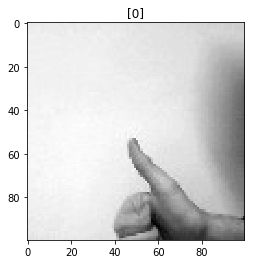

In [4]:
train_X, train_Y, test_X, test_Y = load_data(PATH)

In [11]:
img_size = 100

img_size_flat = 100 * 100

img_shape = (img_size, img_size)

num_channels = 1

num_classes = 2

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(100, 100), cmap='gray')
        
        if cls_pred is None:
            xlabel = f"True: {cls_true[i]}"
        else:
            xlabel = f"True: {cls_true[i]}, Pred: {cls_pred[i]}"
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()    

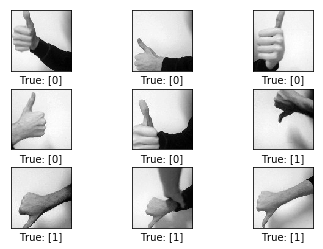

In [15]:
images = train_X[332:342]

cls_true = train_Y[332:342]

plot_images(images=images, cls_true=cls_true)

## Data preprocessing

In [16]:
def preprocess_images(X):
    X = (X / 255 * 0.99) + 0.01